# Spatial Data Processing

As we have seen in the previous chapter, spatial data comes in a wide variety
of forms. Much of  the power of spatial analysis flows from the ability
to consider the spatial relationships between processes reflected in different
geographical datasets. We can also leverage spatatial analysis to consider the
geographical relationships between observations from the *same* dataset.
**Deterministic spatial analysis** formalizes these spatial relationships.
 By deterministic we mean that the geometric coordinates of the
spatial objects are free from any noise, error, or random variation. The focus
of deterministic analysis is then on the spatial predicates, topologically
invariant binary-spatial relationships, between spatial entities. These spatial
predicates power spatial database systems such
as PostGIS, Oracle Spatial, and others.  

The types of questions/queries that deterministic analysis can answer include:

- *Given two data series, one of points and one of polygons, find the polygon
  that containing each point*.
- *How many points from the first series, does each polygon in the second
  series contain*?
- *Given a set of coffee shops, represented as  points in a city, and a list of
  addresses for rental properties, determine the
  closest coffee shop for each rental property*

In this chapter we explore the use of several different forms of deterministic
spatial analysis, through two example *Vignettes*. We begin with a point
dataset that reports the location of airports across the world. Using the
airports, we will explore different types of spatial queries that filter the
data by regions. We also combine the point data set with a polygonal dataset
for countries and carry out a spatial join that defines the country for each
airport. The second vignette focuses on a point dataset representing Airbnb
listings in San Diego, California. We explore the listing prices across the
point set and then use spatial joins to aggregate the prices by census tracts.
We also combine the Airbnb data with a second point set on cafe locations in
the region to carry out a market analysis of potential demand for each cafe
using spatial tessellations.

## Vignette: Airports 

Airports are interesting entities. They are nodes that connect a network of national and international flows, and are its most visible realization. Where they are located is a function of several factors such as the population they are trying to serve, their level of income, the demand for flying, etc. However their exact location is far from the only possible one. Physically speaking, an airport could be built in many more places than where it ends up. This make the process behind an interesting one to explore through the overall "appearance" of their locations; that is, through its pattern.

In this vignette, we will use a preprocessed open dataset. This dataset provides the location of airports in many different countries, alongside an indication of their size and importance to the air transit network. Before we start analyzing it, we need to load it:

In [26]:
import pandas as pd
import geopandas as gpd
# Load GeoJSON file
air = gpd.read_file('../data/airports/airports_clean.geojson')
# Check top of the table
air.head()

,scalerank,featurecla,type,name,abbrev,location,gps_code,iata_code,wikipedia,natlscale,...,name_ru,name_sv,name_tr,name_vi,name_zh,wdid_score,ne_id,x,y,geometry
0,9,Airport,small,Sahnewal,LUH,terminal,VILD,LUH,http://en.wikipedia.org/wiki/Sahnewal_Airport,8.0,...,None,Ludhiana Airport,None,None,None,4,1159113785,8.455503e+06,3.613331e+06,POINT (8455502.604 3613330.733)
1,9,Airport,mid,Solapur,SSE,terminal,VASL,SSE,http://en.wikipedia.org/wiki/Solapur_Airport,8.0,...,None,None,None,None,None,4,1159113803,8.452830e+06,1.993750e+06,POINT (8452829.548 1993750.242)
2,9,Airport,mid,Birsa Munda,IXR,terminal,VERC,IXR,http://en.wikipedia.org/wiki/Birsa_Munda_Airport,8.0,...,None,M. O. Ranchi,None,Sân bay Birsa Munda,蘭契,4,1159113831,9.498179e+06,2.670488e+06,POINT (9498179.375 2670487.543)
3,9,Airport,mid,Ahwaz,AWZ,terminal,OIAW,AWZ,http://en.wikipedia.org/wiki/Ahwaz_Airport,8.0,...,None,Ahwaz International Airport,Ahvaz Havalimanı,Sân bay Ahvaz,阿瓦士,4,1159113845,5.426503e+06,3.677395e+06,POINT (5426503.078 3677395.464)
4,9,Airport,mid and military,Gwalior,GWL,terminal,VIGR,GWL,http://en.wikipedia.org/wiki/Gwalior_Airport,8.0,...,None,Gwalior Airport,None,Sân bay Gwalior,瓜廖爾,4,1159113863,8.707101e+06,3.034483e+06,POINT (8707100.952 3034482.999)


At first brush, a point pattern is essentially the collective shape a bunch of points create. Given the table contains the coordinates of each airport in a map projection, the quickest way to get a first sense of what the data look like is to plot the coordinates of airports as points, like a scatterplot:

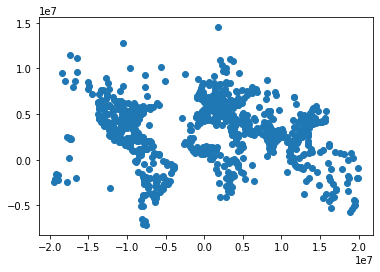

In [27]:
# Plot XY coordinates
import matplotlib.pyplot as plt
plt.scatter(air.x, air.y)

This is not very pretty but that is not our purpose. Our goal was to get a quick first picture and this approach has done the job. Things we can learn from this figure include the fact the overall shape should look familiar to anyone who's seen a map of the world and that, thus, the data do not seem to have any obvious errors. We can then move on to do more interesting things with it.

The first extension is to bring geographic context. Although the shape of the figure above might be familiar, it still takes some effort to identify where different dots are placed on the surface of the Earth. An easy solution to make this easier is to overlay it with a tile map downloaded from the internet. Let us do just that. 

First, we'll download the tiles into an image object, and then we will plot it together with the airports dataset.

In [28]:
import contextily as ctx
# Download tiles for the bounding box of the airport's GeoDataFrame
%time img, ext = ctx.bounds2img(*air.total_bounds, 2)

CPU times: user 15.1 ms, sys: 436 µs, total: 15.6 ms
Wall time: 14.8 ms


The method `bounds2img` (from the library `contextily`, `ctx` for short) returns the image object (`img`) and also an auxilliary tuple with its exact geographic bounds:

In [29]:
ext

(-20037508.342789244,
 20037508.342789244,
 -10018754.171394624,
 20037508.342789244)

This allows us then to match it up with other data which is also expressed in the same coordinate reference system (CRS). Let us produce a slightly more useful image than above:

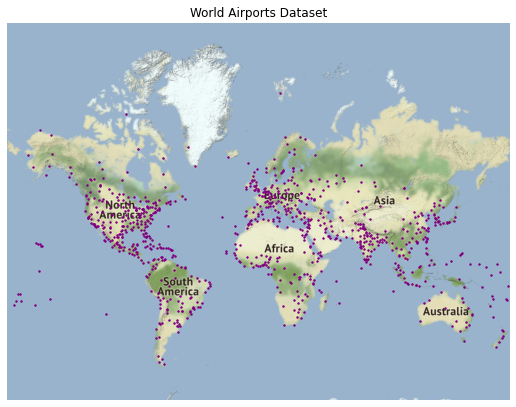

In [30]:
# Set up figure and axes
f, ax = plt.subplots(1, figsize=(9, 9))
# Display tile map
ax.imshow(img, extent=ext)
# Display airports on top
ax.scatter(air.x, air.y, c='purple', s=2)
# Remove axis
ax.set_axis_off()
# Add title
ax.set_title('World Airports Dataset')
# Display
plt.show()

Now this looks a bit better!

### Point-in-polygon visualization

Commonly, we either need or want to link points to areal geographies that allow us to augment their attribute list, or to look at the problem at hand from a new perspective. Maybe because the process we are interested in operates at a more aggregated level, or maybe because by aggregating we can obtain a view into the data that makes it simpler to understand. 

For example, the figure above gives us a good sense about how airports are distributed overall but, in particularly dense areas like Europe, it is hard to see much. By aggregating them to say the country geography, we can consider new sets of questions such as which countries have most airports or which ones have a larger density. This works because the geography we want to aggregate it to, countries, is meaningful. This means it has some inherent structure that confers value. In this case, countries are relevant entities and a crucial piece in arranging the world.

The first thing we need to do to create a country map is to have country (spatial) data. Let us load up a cleaned table with countries:

In [31]:
# Load up shapefile with countries
ctys = gpd.read_file('../data/countries/countries_clean.gpkg')

And, same as with any new dataset, let us have a quick look at what it looks like and how it stacks up with the other data we have collected along the way:

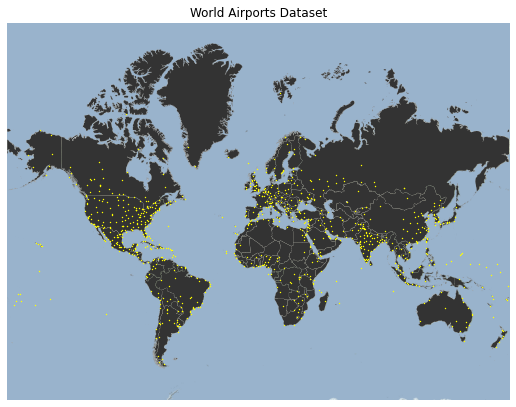

In [32]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add tile map
ax.imshow(img, extent=ext)
# Display country layer
ctys.plot(ax=ax, linewidth=0.1, \
          edgecolor='0.8', color='0.2')
# Display airport locations
ax.scatter(air.x, air.y, c='yellow', s=2, linewidth=0.)
# Remove axis
ax.set_axis_off()
# Add title
ax.set_title('World Airports Dataset')
# Display
plt.show()

Again nothing new or too exciting from this figure, but this is good news: it means our data are aligned and match up nicely. So we can move on to more interesting ventures.

The next thing that we might want to do to obtain country counts of airports is to link each airport with the country where it is located. Sometimes, we are lucky and the airport table will include a column with that information. In this case, we need to create it for ourselves. This is a well-known problem in geometry and GIS and is commonly known as point-in-polygon: to determine whether a given point is inside a polygon. With that operation solved, linking airports to countries amoutns to a bit of house keeping. We will first explore in pure Python how that algorithm can be easily implemented from scratch so it becomes clear what steps are involved; then we will see a much more efficient and fast implementation that we should probably use when need to perform this operation in other contexts.

Creating a manual, brute-force implementation of a spatial join is not very difficult, if one has solved the problem of checking whether a point is inside a polygon or not. Thanks to the library that provides geometry objects to `geopandas` (`shapely`), this is solved in Python. For example, we can easily check if the first dot on the airports table is inside the first polygon in the countries table:

In [33]:
# Single out point
pt = air.iloc[0]['geometry']
# Single out polygon
poly = ctys.iloc[0]['geometry']
# Check whether `poly` contains `pt`
poly.contains(pt)

False

That easy. As we can see, the method `contains` in any `shapely` geometry makes it trivial. So, the first airport in the list is not in the first country of the list.

To find which country every airport is in easily (albeit not very efficiently!), we need to sift through all possible combinations to see if any of them gives us a match. Once we find it for a given airport, we need to record that and move on, no need to keep checking. That is exactly what we do in the cell below:

In [34]:
%%time
# Set up an empty dictionary to populate it with the matches
airport2country = {aID: None for aID in air.index}
# Loop over every airport
for aID, row_a in air.iterrows():
    # Single out location of the airport for convenience
    pt = row_a['geometry']
    # Loop over every country
    for cID, row_p in ctys.iterrows():
        # Single out country polygon for convenience
        poly = row_p['geometry']
        # Single out country name for convenience
        cty_nm = row_p['ADMIN']
        # Check if the country contains the airport
        if poly.contains(pt):
            # If so, store in the dictionary
            airport2country[aID] = cty_nm
            # Move on to the next airport, skipping remaining 
            # countries (an airport cannot be in two countries 
            # at the same time)
            break
airport2country = pd.Series(airport2country)

CPU times: user 16.2 s, sys: 7.74 ms, total: 16.2 s
Wall time: 16.2 s


Once run, we can check the content of the dictionary we have created (after converting it to a `Series` for convenience):

In [ ]:
pd.DataFrame({'Airport Name': air['name'], 'Country': airport2country}).head(10)

---

Although interesting from a pedagogical standpoint, in practive, very rarely do we have to write a spatial join algorithm from scratch. More commonly, we will use one of the already available packaged methods. As mentioned, this is a fairly standard GIS operation, and the GIS community has spent a lot of effort to build optimized algorithms that can conveniently do the job for us. In `GeoPandas`, this is as simple as calling `sjoin`:

In [ ]:
# Spatial join
%time air_w_cty = gpd.sjoin(air, ctys)
air_w_cty.head()

Instead of the $\approx$47 seconds it took our homemade algorithm, the one above did a full join in just over two seconds! Through this join also, it is not only the IDs that are matched, but the entire table. Let us quickly compare whether the names match up with our own:

In [ ]:
# Display only top six records of airport and country name
# Note that the order of the `sjoin`ed table is not the same
# as ours but it can easily be rearranged using original indices
air_w_cty.loc[range(6), ['name', 'ADMIN']]

Voila! Both tables seem to match nicely.

To finish this vignette, let us explore which countries have the most airports through a simple choropleth. The only additional step we need to take is to obtain counts per country. But this is pretty straightforward now we have them linked to each airport. To do this, we use the `groupby` operation which, well, groups by a given column in a table, and then we apply the method `size`, which tells us how many elements every group has:

In [ ]:
# Group airports by country and count by group
cty_counts = air_w_cty.groupby('ADMIN')\
                      .size()

Then a choropleth is as simple as:

In [ ]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Index countries by the name, append the airport counts
# (which are themselves indexed on country names too),
# Fill any missing value in the count with zero (no counts
# in this context means zero airports), and display choropleth
# using quantiles
p = ctys.set_index('ADMIN')\
        .assign(airport_count=cty_counts)\
        .fillna(0)\
        .plot(column='airport_count', scheme='Quantiles', \
              ax=ax, linewidth=0, legend=True)
# Display map
plt.show()

Maybe unsurprisingly, what we find after all of this is that larger countries such as Canada, US, or Russia, have more airports. However, we can also find interesting insights. Some countries with similar size, such as France or Germany and some African countries such as Namibia have very different numbers. This should trigger further questions as to why that is, and maybe even suggest some tentative answers.

And additional view that might be of interest is to display airport counts, but weighted by the area of the country. In other words, to show airport density. The idea behind it is to explore the variation in probabilities of an airport to be located in a given country, irrespective of how large that country is. Let us first create the densities:

In [ ]:
# Airport density
# Note since the CRS we are working with is expressed in Sq. metres,
# we rescale it so the numbers are easier to read
airport_density = cty_counts * 1e12 / ctys.set_index('ADMIN').area

airport_density.head()

And now we are ready to plot!

In [ ]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Index countries by the name, append the airport densities
# (which are themselves indexed on country names too),
# Fill any missing value in the count with zero (no number
# in this context means zero airports), and display choropleth
# using quantiles
p = ctys.set_index('ADMIN')\
        .assign(airport_dens=airport_density)\
        .fillna(0)\
        .plot(column='airport_dens', scheme='Quantiles', \
              ax=ax, linewidth=0, legend=True)
# Display map
plt.show()

This map gives us a very different view. Very large countries are all of a sudden "penalized" and some smaller ones rise to the highest values. Again, how to read this map and whether its message is interesting or not depends on what we are after. But, together with the previous one, it does highlight important issues to consider when exploring uneven spatial data and what it means to display data (e.g. airports) through specific geographies (e.g. countries).


## Vignette: Airbnb Prices in San Diego

Our second vignette changes the spatial scale to examine the distribution of
Airbnb listings in San Diego California. We begin by reading the listings, 
 which are stored in a comma separated file (csv):


In [ ]:
df = pd.read_csv('../data/sandiego/listings.csv')
len(df)


Examination of the dataframe reveals that the location information is encoded
in the columns `longitude` and `latitude`.  We will use these columns together
with the `Point` class from **shapely** to create a geodataframe:

In [ ]:
from shapely.geometry import Point

In [ ]:
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

In [ ]:
import geopandas as gpd

In [ ]:
gdf = gpd.GeoDataFrame(df)

In [ ]:
gdf['geometry'] = geometry

In [ ]:
gdf.plot()

The listings are represented as point objects, and what we are interested in is
the spatial distribution of the listing prices across the market. So unlike the
airport dataset above where we were focusing on the locations of the points,
here we extend the analysis to consider the locations and an attribute that is
measured at each of the locations.

Before we analyze the spatial distribution of the listings, we have to convert
the data type of the listing column as it is currently encoded as a string:

In [ ]:
gdf.price

In [ ]:
gdf['price'] = gdf['price'].apply(lambda x: x.replace('$', '').replace(',', '')).astype(float)

In [ ]:
gdf.price

In [ ]:
crs = {'init': 'epsg:4326'}
gdf.crs = crs

With the listing variable converted, we can now proceed to visualize the
spatial distribution:

In [ ]:
gdf.plot(column='price', legend=True, scheme='quantiles', figsize=(16,16))

This is somewhat informative, but there are several issues with approaching the
analysis in this fashion. Chief among these is the occlusion of listings in
areas with high density. The size of the points also makes it challenging to
develop a systematic view of the spatial variation in the listing prices.

We can address these issues through spatial aggregation. That is, similar to
what we did for the airport dataset, we can use a spatial join to associate each
listing with its enclosing  polygon. Once we have that information, we can use
database methods to perform aggregation queries to get the average listing
price per polygon.

For our polygons we will use census tracts that we have downloaded for the
state of California:

In [ ]:
tracts = '../data/sandiego/tl_2019_06_tract.shp'
tracts = gpd.read_file(tracts)

In [ ]:
tracts.plot()

This gives us all the tracts for the state, but our market analysis is focusing on
the case of San Diego. We can use a Pandas query to create a more focused dataframe:

In [ ]:
sd_tracts = tracts[tracts.COUNTYFP=='073']

In [ ]:
sd_tracts.plot()

Visual examination of the tracts reveals one idiosyncratic tract. The elongated
coastal tract actually has a boundary that extends into the Pacific Ocean.
This will induce visual noise in any subsequent analysis, so let's remove it.

The question is how to remove it? 

Fortunately for this case, the tract in question is the extreme west tract, so
we can exploit this information to find, and remove, the row in the dataframe:


In [ ]:
bounds = sd_tracts.bounds

In [ ]:
bounds

In [ ]:
bounds.minx.min()

In [ ]:
bounds[bounds.minx==bounds.minx.min()]

In [ ]:
sd_tracts[bounds.minx==bounds.minx.min()].plot()

In [ ]:
sd_tracts[bounds.minx!=bounds.minx.min()].plot()

In [ ]:
sd_tracts = sd_tracts[bounds.minx!=bounds.minx.min()]

Having removed the coastal tract, we can now do a spatial join to associate a
tract with each listing point:

In [ ]:
 gdf.geometry

In [ ]:
j = gpd.sjoin(gdf, sd_tracts, how='inner', op='within')

We see a warning that alerts us to a problem with the coordinate reference systems
being different between the two dataframes. Since our spatial join is based on
the spatial relationship of containment (`within`), the CRSs have to be
identical for this to be correct.

Let's fix this and continue on:

In [ ]:
gdf = gdf.to_crs(sd_tracts.crs)

In [ ]:
j = gpd.sjoin(gdf, sd_tracts, how='inner', op='within')

In [ ]:
j.shape

The result of the spatial join is that the listings dataframe has now been
extended to add a column that identifies the census tract that contains
the point for the listing.

From the perspective of an individual listing point, this is a *one-to-one* spatial
relationship. That is, a point can be within only one census tract, since the
census tracts are [planar
enforced](https://books.google.com/books?id=-FbVI-2tSuYC&pg=PA186&lpg=PA186&dq=planar+enforcement+theobald&source=bl&ots=SpOsACcrbP&sig=ACfU3U1CPniL-YpWCt0ml--XIP5_d3fkWA&hl=en&sa=X&ved=2ahUKEwjC-5LX1_fqAhWEHzQIHcNwC-8Q6AEwDXoECAoQAQ#v=onepage&q=planar%20enforcement%20theobald&f=false)
and do not overlap.

From the perspective of the census tracts, the relationship is of a
*one-to-many* form, since one census tract can contain multiple listings. 
And, it is this cardinality that we want to leverage in aggregating the listing
information by tract. For example, we can get the number of listings within
each census tract using a `grouby` method on the dataframe:


In [ ]:
j.groupby(by='GEOID').count()

In [ ]:
j[['price', 'GEOID']]

Here we have used the `count` method on the dataframe that is generated from
the `groupby`. If we change the `count` method to `mean`, we will get the
average listing price by census tract:

In [ ]:
j[['price','GEOID']].groupby(by='GEOID').mean()

We then can add this new variable to the tract dataframe:

In [ ]:
tract_mean = j[['price','GEOID']].groupby(by='GEOID').mean()

In [ ]:
sd_tracts = sd_tracts.merge(tract_mean, on='GEOID')

and plot the average listing price by census tract:

In [ ]:
sd_tracts.plot(column='price',legend=True, figsize=(16,16), scheme='quantiles')

Let's add in a basemap for some context:

In [ ]:
west, south, east, north = sd_tracts.total_bounds

In [ ]:
%time img, ext = ctx.bounds2img(west, south, east, north, ll=True, zoom=11)

In [ ]:
sd_tracts = sd_tracts.to_crs(epsg=3857)

In [ ]:
# Set up figure and axes
f, ax = plt.subplots(1, figsize=(16, 16))
# Display tile map
ax.imshow(img, extent=ext)
# Display airports on top
sd_tracts.plot(ax=ax, alpha=0.6, color='green',edgecolor='lightgrey')
#listings.plot(ax=ax, c='green')
#ax.scatter(air.x, air.y, c='purple', s=2)
# Remove axis
#ax.set_axis_off()
# Add title
ax.set_title('San Diego Tracts with Listings')
# Display
plt.show()


In [ ]:
# Set up figure and axes
f, ax = plt.subplots(1, figsize=(16, 16))
# Display tile map
ax.imshow(img, extent=ext)
# Display airports on top
sd_tracts.plot(ax=ax, alpha=0.6, edgecolor='lightgrey',
              column='price', legend=True, scheme='quantiles')
#listings.plot(ax=ax, c='green')
#ax.scatter(air.x, air.y, c='purple', s=2)
# Remove axis
#ax.set_axis_off()
# Add title
ax.set_title('San Diego Tracts Listing Prices')
# Display
plt.show()


The visual analysis of the listing prices at the tract scale has addressed the
problems we encountered in analyzing the points layer directly. There is a
trade-off as we switch from the point to areal unit layers, as the latter
results from an aggregation of the information in the former. In subsequent
chapters, we will be introducing methods that are appropriate for the deeper
statistical analysis of these different types of spatial support. Here we only
wanted to introduce methods of spatial data processing that allow us to
construct the variables and layers that would feed into those analyses.


### Cafe Sheds

We close this chapter with the application of a final set of deterministic
spatial analytical methods that provide insights on the market structure of
cafes in the San Diego region.

Our data come from OpenStreetMap and have been extracted using QGIS and the OSM
plugin to create a geopackage that we read in here:

In [ ]:
cafes = gpd.read_file('../data/sandiego/sdcafes.gpkg')

We can explore this data frame through some plotting and introspection:

In [ ]:
cafes.plot()

In [ ]:
cafes.crs

Again, we grab a basemap for context:

In [ ]:
west, south, east, north = cafes.total_bounds


In [ ]:
%time img, ext = ctx.bounds2img(west, south, east, north, ll=True, zoom=11)

In [ ]:
ext

In [ ]:
cafes.total_bounds

and we need to set the CRS of our cafes, and listings, to web mercator so that we
can plot them together with our basemap to get a better understanding of the
spatial relationships between the cafes and the airbnb listings:

In [ ]:
cafes = cafes.to_crs(epsg=3857)

In [ ]:
listings = j.to_crs(epsg=3857)

In [ ]:
# Set up figure and axes
f, ax = plt.subplots(1, figsize=(9, 9))
# Display tile map
ax.imshow(img, extent=ext)
# Display airports on top
cafes.plot(ax=ax, c='purple')
listings.plot(ax=ax, c='green')
#ax.scatter(air.x, air.y, c='purple', s=2)
# Remove axis
#ax.set_axis_off()
# Add title
ax.set_title('San Diego Cafes (Purple) and Air BnB Listings (Green)')
# Display
plt.show()


We see that the spatial extent of the cafes is much larger than that of the
listings, so let's subset our cafes to those within the extent of the listings:

In [ ]:
listings.total_bounds

In [ ]:
%time img, ext = ctx.bounds2img(*listings.total_bounds, zoom=11)

In [ ]:
w,s,e,n = listings.total_bounds

In [ ]:
cafes = cafes.cx[w:e,s:n]

In [ ]:
# Set up figure and axes
f, ax = plt.subplots(1, figsize=(9, 9))
# Display tile map
ax.imshow(img, extent=ext)
# Display airports on top
listings.plot(ax=ax, c='green')
cafes.plot(ax=ax, c='purple', alpha=0.5)

#ax.scatter(air.x, air.y, c='purple', s=2)
# Remove axis
#ax.set_axis_off()
# Add title
ax.set_title('San Diego Cafes (Purple) and Air BnB Listings (Green)')

# Display
plt.show()


Plotting the two point sets together, we encounter the same occlusion problem,
only now it takes on a more complex form since listings can occlude other
listings, cafes can occlude other cafes, and cafes can occlude listings (since
cafes are drawn last).

One way around these issues is to ask more particular questions about the
spatial relationships between the two point sets. For example, one very
important question (from the perspective of  a coffee aficionado) we may
want to answer is "what is the closest cafe to my listing?"

To answer this question we develop [Voronoi polygons](http://jwilson.coe.uga.edu/EMAT6680Fa08/Kuzle/Math%20in%20Context/Voronoi%20diagrams.html)
for each cafe. These polygons comprise a tessellation of the extent such that
there is one polygon for each cafe, and these polygons define the set of points
for which that cafe is the closest of all cafes in San Diego.

Because these polygons are planar enforced, we know that each of our listings
will be contained by one, and only one, of the Voronoi polygons. Once we know
which polygon a listing is within, we also know which cafe is closet to that
listing - and that will be the cafe that is the generator point for the polygon.

We construct the Voronoi polygons using **libpysal**:


In [ ]:
import libpysal

In [ ]:
sheds, generators = libpysal.cg.voronoi.voronoi_frames(list(zip(cafes.geometry.x.values, cafes.geometry.y.values)))

In [ ]:
sheds.plot(figsize=(16,16))

and add these "cafe sheds" together with our basemap:

In [ ]:
sheds.crs = 'epsg:3857'

In [ ]:
w,s,e,n = sheds.total_bounds

In [ ]:
# Set up figure and axes
f, ax = plt.subplots(1, figsize=(16,16))
# Display tile map
ax.imshow(img, extent=ext)
# Display airports on top
#listings.plot(ax=ax, c='green')
sheds.plot(ax=ax, alpha=.7, edgecolor='white')
cafes.plot(ax=ax, c='purple', alpha=0.5)
#listings.plot(ax=ax, c='green')


#ax.scatter(air.x, air.y, c='purple', s=2)
# Remove axis
#ax.set_axis_off()
# Add title
ax.set_title('San Diego Cafe Sheds')
# Display
ax.set_xlim((w,e))
ax.set_ylim((s,n))
ax.set_axis_off()

plt.show()


### Closest cafe

To find the closest cafe to each listing, we do a spatial join of the listings
dataframe with the coffee sheds (voronoi polygons):

In [ ]:
sheds.crs = 'epsg:3857'

In [ ]:
cc = gpd.sjoin(listings.drop(['index_right'], axis=1), sheds, how='inner', op='within')

In [ ]:
cc.head()

In [ ]:
cc.shape

In [ ]:
cc.rename(columns={'index_right': 'cafe'}, inplace=True)

In [ ]:
cc.head()

This new dataframe has one record for each listing, and records the coffee
shed, or Voronoi polygon,
that contains the listing.

## Choropleth of Demand by Coffee Shed

From the perspective of an airbnb renter, we have given them what they need -
the identification of their closest cafe. For the owners of the cafe, what
would be of interest is how many such renters are within their Voronoi polygon.
We can determine this number for each cafe in the data set in a similar fashion
to what we've done above for the airports and listing by tract: do a groupby of
the listings in each shed polygon:


In [ ]:
cc.groupby(by='cafe').count()

Here the `id` column is the count of the number of listings within the polygon
associated with the cafe in the first column. Essentially this is counting up
how many times a particular cafe appears in the `cafe` column:

In [ ]:
cc.cafe

and we can find out how many cafes (out of all cafes in San Diego) are the
nearest cafe to at least one listing:

In [ ]:
generators.iloc[cc.cafe.unique()] # cafes that are a nearest neighbor to at least 1 listing

Now we are in a position to visualize the spatial distribution of coffee demand
across the sheds. Let's first rename our dataframe:

In [ ]:
demand = cc[['cafe', 'listing_url']].groupby(by='cafe').count()
demand.rename(columns={'listing_url':'listings'}, inplace=True)

In [ ]:
demand.head()

In [ ]:
demand.shape

In [ ]:
demand.index

We can join the demand dataframe to the sheds dataframe. This adds the demand
column to the shed dataframe:

In [ ]:
sheds = sheds.join(demand)

In [ ]:
sheds.head()

In [ ]:
sheds

There are cafes with sheds that do not contain any listings and these have a
`Nan` in their demand column. We can set these values to 0:

In [ ]:
sheds = sheds.fillna(0)

In [ ]:
sheds

And finally, we can map the number of airbnb listings in each coffee shed:

In [ ]:
# Set up figure and axes
f, ax = plt.subplots(1, figsize=(16,16))
# Display tile map
ax.imshow(img, extent=ext)
# Display airports on top
#listings.plot(ax=ax, c='green')
sheds.plot(ax=ax, alpha=.7, edgecolor='white', column='listings', legend=True, scheme='quantiles')
#cafes.plot(ax=ax, c='purple', alpha=0.5)
#listings.plot(ax=ax, c='green')


#ax.scatter(air.x, air.y, c='purple', s=2)
# Remove axis
#ax.set_axis_off()
# Add title
ax.set_title('Number of Airbnb Listings by San Diego Cafe Sheds')
# Display
ax.set_xlim((w,e))
ax.set_ylim((s,n))
ax.set_axis_off()

plt.show()


## Exercises

1. Which coffee shed has the highest listing price?

2. How distant are the highest and lowest listings?
3. Generate a choropleth that expresses listing intensity (listings per square
   kilometer) by coffee shed.

In [ ]:
sheds.geometry

In [ ]:
sheds.geometry.area

In [ ]:
sheds['area'] = sheds.geometry.area / 1000000

In [ ]:
# Set up figure and axes
f, ax = plt.subplots(1, figsize=(16,16))
# Display tile map
ax.imshow(img, extent=ext)
# Display airports on top
#listings.plot(ax=ax, c='green')
sheds.plot(ax=ax, edgecolor='grey', column='area', legend=True,
          scheme='fisher_jenks',
          classification_kwds={'k':10})
#cafes.plot(ax=ax, c='purple', alpha=0.5)
#listings.plot(ax=ax, c='green')


#ax.scatter(air.x, air.y, c='purple', s=2)
# Remove axis
#ax.set_axis_off()
# Add title
ax.set_title('San Diego Cafe Sheds Area (km2)')
# Display
ax.set_xlim((w,e))
ax.set_ylim((s,n))
ax.set_axis_off()

plt.show()


In [ ]:
sheds['lintensity'] = sheds['listings'] / sheds['area']
# Set up figure and axes
f, ax = plt.subplots(1, figsize=(16,16))
# Display tile map
ax.imshow(img, extent=ext)
# Display airports on top
#listings.plot(ax=ax, c='green')
sheds.plot(ax=ax, edgecolor='grey', column='lintensity', legend=True,
          scheme='fisher_jenks',
          classification_kwds={'k':10})
#cafes.plot(ax=ax, c='purple', alpha=0.5)
#listings.plot(ax=ax, c='green')


#ax.scatter(air.x, air.y, c='purple', s=2)
# Remove axis
#ax.set_axis_off()
# Add title
ax.set_title('San Diego Listings Intensity by Cafe Sheds')
# Display
ax.set_xlim((w,e))
ax.set_ylim((s,n))
ax.set_axis_off()

plt.show()


---

<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>.